In [3]:
import pandas as pd
import numpy as np
import glob
import os, inspect
from IPython.display import Image
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from zipfile import ZipFile

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing import sequence

%matplotlib inline

In [5]:
path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) + "/seattle"

zf = ZipFile(str(path) + '.zip', 'r')
zf.extractall(path)

filenames = glob.glob(path + "/*.csv")

data = []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    data.append(df)

reviews = data[0]
listings = data[1]
calendar = data[2]

print("Calendar: " +str(calendar.shape))
print("Listings: " +str(listings.shape))
print("Reviews: " +str(reviews.shape))


#frame = pd.concat(li, axis=0, ignore_index=True)

Calendar: (1393570, 4)
Listings: (3818, 92)
Reviews: (84849, 6)


In [3]:
x = listings[["host_listings_count","accommodates", 
              "bathrooms", "bedrooms", "beds", "number_of_reviews", "review_scores_rating", 
               "reviews_per_month", "price"]]
x= x.dropna()
y = x['price'].str.replace("[$, ]", "").astype("float")
x = x.drop(["price"], axis=1)
print(len(x))
print(len(y))
x.head()

3153
3153


,host_listings_count,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,reviews_per_month
0,3.0,4,1.0,1.0,1.0,207,95.0,4.07
1,6.0,4,1.0,1.0,1.0,43,96.0,1.48
2,2.0,11,4.5,5.0,7.0,20,97.0,1.15
4,2.0,6,2.0,3.0,3.0,38,92.0,0.89
5,1.0,2,1.0,1.0,1.0,17,95.0,2.45


Text(0.5, 1.0, 'Price / Bedroom correlation')

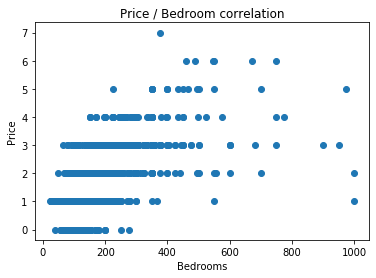

In [4]:
plt.scatter(y, x['bedrooms'])
plt.ylabel('Price')
plt.xlabel('Bedrooms')
plt.title('Price / Bedroom correlation')

In [5]:
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
cross_val_score(clf, x, y, cv=10)

/Users/Loehr/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.04458599, 0.05063291, 0.05849582, 0.07207207, 0.05095541,
       0.05479452, 0.0625    , 0.07936508, 0.06694561, 0.03982301])

## Sentiment Analysis from imdb

In [6]:
vocabulary_size = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

Loaded dataset with 25000 training samples, 25000 test samples


In [19]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [7]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}

max_words = 500

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
batch_size = 512
num_epochs = 2

X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  

model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Train on 24488 samples, validate on 512 samples
Epoch 1/2
24488/24488 [==============================] - 220s 9ms/step - loss: 0.6557 - acc: 0.6607 - val_loss: 0.5354 - val_acc: 0.7207
Epoch 2/2
24488/24488 [==============================] - 221s 9ms/step - loss: 0.4502 - acc: 0.8099 - val_loss: 0.3121 - val_acc: 0.8672


In [10]:
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Test accuracy:", scores[1])

Test accuracy: 0.85736


[0.3404702952671051, 0.85736]